In [45]:
!pip install -r requirements.txt


In [110]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Point
import folium 
from folium.plugins import MarkerCluster, HeatMap

# Cargar data de distritos del Perú (Shapefile)
distritos = gpd.read_file(r"C:\Users\atara\Desktop\Hospitals-Access-Peru\_data\DISTRITOS.shp")

# Cargar data de hospitales (CSV)
hospitales = pd.read_csv(r"C:\Users\atara\Desktop\Hospitals-Access-Peru\_data\IPRESS.csv", encoding="latin1")

In [111]:
# Filtrar hospitales solo en funcionamiento
hospitales = hospitales[hospitales["Condición"] == "EN FUNCIONAMIENTO"]

# Mantener solo los que tienen coordenadas válidas
hospitales = hospitales.dropna(subset=["ESTE", "NORTE"])

# Crear geometría con lat/lon (NORTE= lon, ESTE = lat)
hospitales_gdf = gpd.GeoDataFrame(
    hospitales,
    geometry=gpd.points_from_xy(hospitales["NORTE"], hospitales["ESTE"]),
    crs="EPSG:4326"
)

hospitales

In [112]:
# Puntos del primer distrito de la lista
distritos.geometry[0].boundary.coords.xy  

# Verificar si la columna 'IDDIST' es única para cada distrito
distritos['IDDIST'].is_unique  

# Ver el número de códigos únicos de distritos
distritos['IDDIST'].unique().size  

# Seleccionar solo las columnas relevantes: IDDIST, Distrito y geometría
distritos = distritos[['IDDIST', 'DISTRITO', 'geometry']]

# Renombrar la columna 'IDDIST' como 'UBIGEO' para que sea compatible con la base de hospitales
distritos = distritos.rename(columns={'IDDIST': 'UBIGEO'})

# Revisar los valores de la nueva columna UBIGEO
distritos['UBIGEO']

# Convertir la columna UBIGEO a tipo string y luego a entero
distritos['UBIGEO'] = distritos['UBIGEO'].astype(str).astype(int)

# Mostrar la tabla final de distritos ya preparada
print(distritos.head())

   UBIGEO                DISTRITO  \
0  100902         CODO DEL POZUZO   
1  100904             TOURNAVISTA   
2  250305  ALEXANDER VON HUMBOLDT   
3  250302                 IRAZOLA   
4  250304                 NESHUYA   

                                            geometry  
0  POLYGON ((-75.31797 -9.29529, -75.3171 -9.2975...  
1  POLYGON ((-74.64136 -8.82302, -74.64036 -8.828...  
2  POLYGON ((-75.02253 -8.74193, -75.02267 -8.742...  
3  POLYGON ((-75.13864 -8.56712, -75.13956 -8.569...  
4  POLYGON ((-75.01589 -8.44637, -75.01585 -8.446...  


In [113]:
#Se aplica CRS: 
distritos = distritos.to_crs(epsg=4326)
distritos.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [114]:
# Unir la base hospitales a distritos
hospitales_por_distrito = gpd.sjoin(hospitales_gdf, distritos, how="inner", predicate="within")

# Verifica qué columnas tiene después del sjoin
print(hospitales_por_distrito.columns)

# Contar hospitales por UBIGEO
conteo = hospitales_por_distrito.groupby("UBIGEO_right").size().reset_index(name="num_hospitales")

# Renombrar
conteo = conteo.rename(columns={"UBIGEO_right": "UBIGEO"})

# Unir el conteo a la capa de distritos en una nueva variable
distritos_hosp = distritos.merge(conteo, on="UBIGEO", how="left")

# Reemplazar valores nulos por 0 y asegurar tipo entero
distritos_hosp["num_hospitales"] = distritos_hosp["num_hospitales"].fillna(0).astype(int)

# Revisar tabla final de distritos con conteo
print(distritos_hosp[["UBIGEO", "DISTRITO", "num_hospitales"]].head())


Index(['Institución', 'Código Único', 'Nombre del establecimiento',
       'Clasificación', 'Tipo', 'Departamento', 'Provincia', 'Distrito',
       'UBIGEO_left', 'Dirección', 'Código DISA', 'Código Red',
       'Código Microrred', 'DISA', 'Red', 'Microrred', 'Código UE',
       'Unidad Ejecutora', 'Categoria', 'Teléfono', 'Tipo Doc.Categorización',
       'Nro.Doc.Categorización', 'Horario', 'Inicio de Actividad',
       'Director Médico y/o Responsable de la Atención de Salud', 'Estado',
       'Situación', 'Condición', 'Inspección', 'NORTE', 'ESTE', 'COTA',
       'CAMAS', 'geometry', 'index_right', 'UBIGEO_right', 'DISTRITO'],
      dtype='object')
   UBIGEO                DISTRITO  num_hospitales
0  100902         CODO DEL POZUZO               6
1  100904             TOURNAVISTA               4
2  250305  ALEXANDER VON HUMBOLDT               3
3  250302                 IRAZOLA               6
4  250304                 NESHUYA               7


MAPA 1:  Total de hospitales públicos por distrito

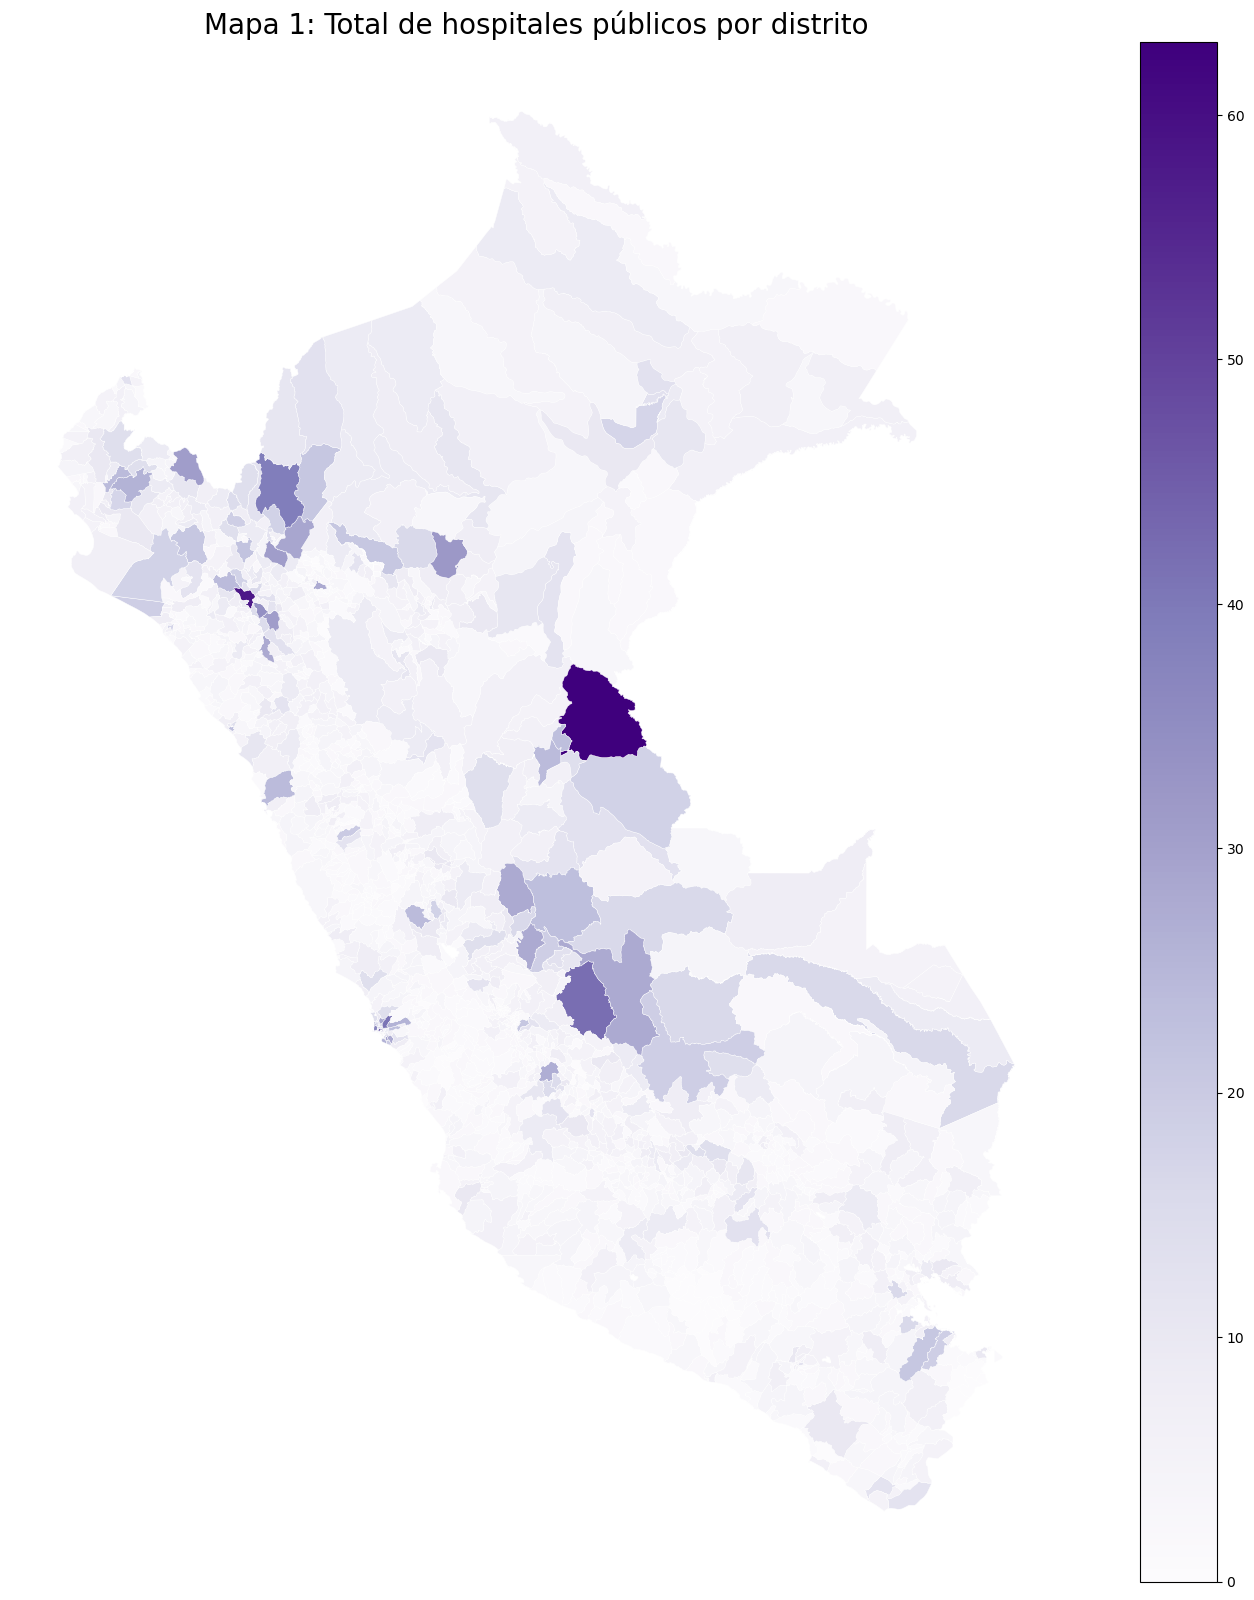

In [115]:
#Hospitales públicos por distrito
fig, ax = plt.subplots(figsize=(20, 20))

distritos_hosp.plot(
    column="num_hospitales",   # usamos la variable de conteo
    ax=ax,
    cmap="Purples",
    legend=True,
    edgecolor="white",
    linewidth=0.3
)

#Mostramos el mapa:

plt.title("Mapa 1: Total de hospitales públicos por distrito", fontsize=20)
plt.axis("off")
plt.show()

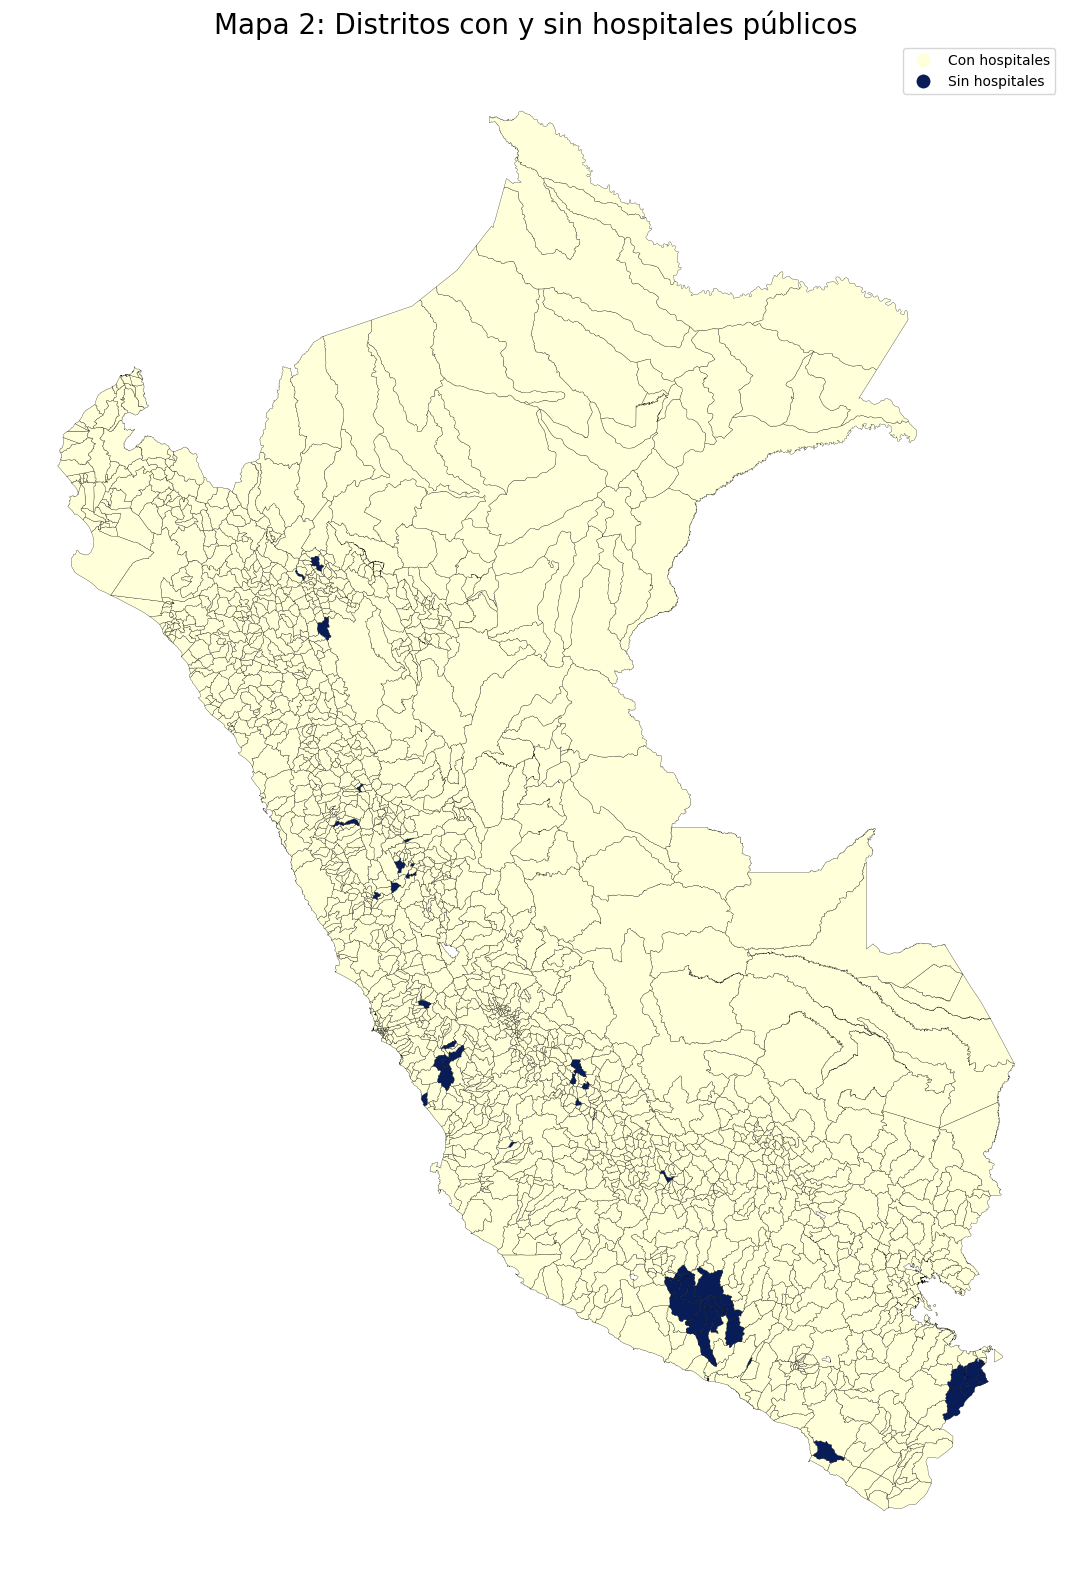

In [121]:
#    Mapa 2: Resalte los distritos con cero hospitales

# Crear columna categórica: 0 hospitales vs 1 o más
distritos_hosp["tiene_hospital"] = distritos_hosp["num_hospitales"].apply(
    lambda x: "Sin hospitales" if x == 0 else "Con hospitales"
)

# MAPA 2:
fig, ax = plt.subplots(figsize=(20, 20))

distritos_hosp.plot(
    column="tiene_hospital",      # variable categórica creada
    ax=ax,
    cmap="YlGnBu",              # paleta de colores (amarillo vs verde)
    legend=True,
    edgecolor="black",
    linewidth=0.2
)

# Mostrar mapa
plt.title("Mapa 2: Distritos con y sin hospitales públicos", fontsize=20)
plt.axis("off")
plt.show()

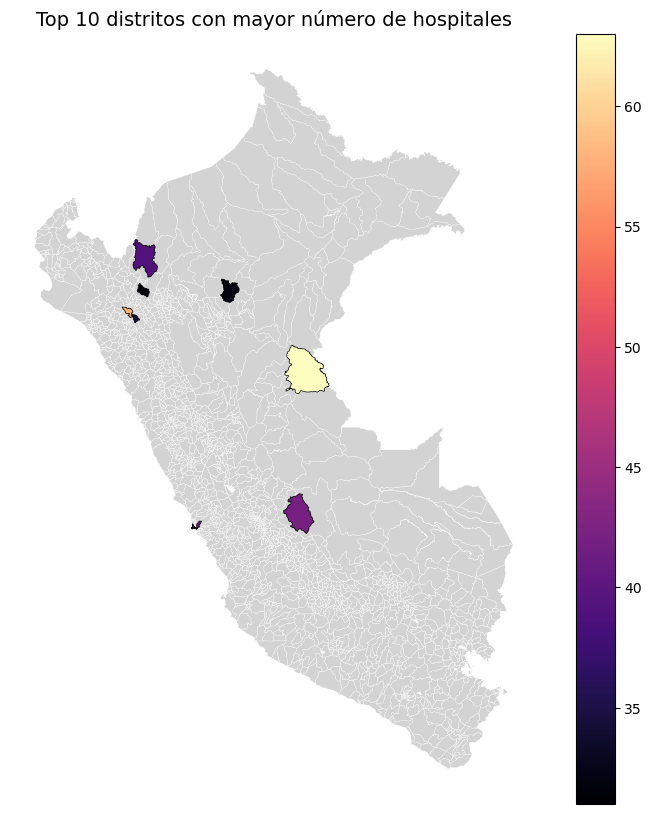

In [127]:
#   Mapa3: Los 10 distritos con mayor número de hospitales (escala de colores diferenciada).

# Seleccionar los 10 distritos con más hospitales
top10 = distritos_hosp.sort_values("num_hospitales", ascending=False).head(10)

# Crear mapa
fig, ax = plt.subplots(figsize=(10, 10))

distritos_hosp.plot(ax=ax, color="lightgrey", edgecolor="white", linewidth=0.2) #Fomrato: todos los distritos en gris claro

#Pintar solo top 10
top10.plot(
    column="num_hospitales",
    ax=ax,
    cmap="magma",      #paleta de colores
    legend=True,       #legenda
    edgecolor="black",
    linewidth=0.5
)

#Mostrar mapa:
ax.set_title("Top 10 distritos con mayor número de hospitales", fontsize=14)
ax.axis("off")

plt.show()



TAREA 2:  Análisis a nivel departamental

In [136]:
# Agrupar hospitales por departamento
hospitales_departamento = (
    hospitales_gdf
    .groupby("Departamento")
    .size()
    .reset_index(name="num_hospitales")
    .sort_values("num_hospitales", ascending=False)
)

# Mostrar tabla
hospitales_departamento.reset_index(drop=True)


,Departamento,num_hospitales
0,CAJAMARCA,845
1,LIMA,774
2,JUNIN,493
3,PIURA,442
4,AMAZONAS,417
5,ANCASH,416
6,PUNO,407
7,AYACUCHO,387
8,SAN MARTIN,379
9,APURIMAC,375


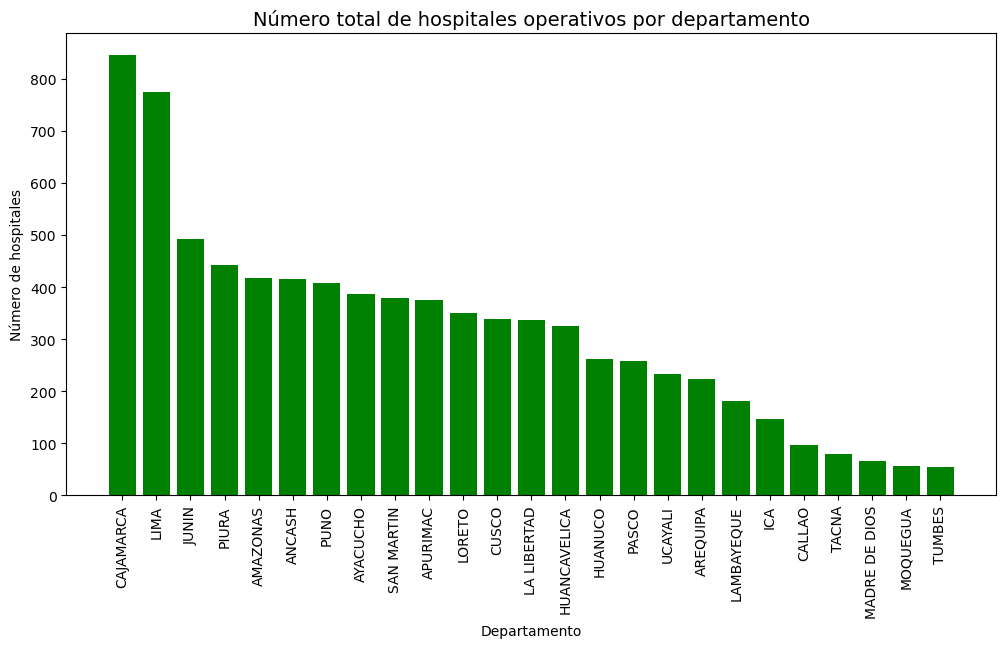

In [135]:
#Gráfico de barras
plt.figure(figsize=(12, 6))
plt.bar(
    hospitales_departamento["Departamento"],
    hospitales_departamento["num_hospitales"],
    color="green"
)
plt.xticks(rotation=90)
plt.title("Número total de hospitales operativos por departamento", fontsize=14)
plt.xlabel("Departamento")
plt.ylabel("Número de hospitales")
plt.show()

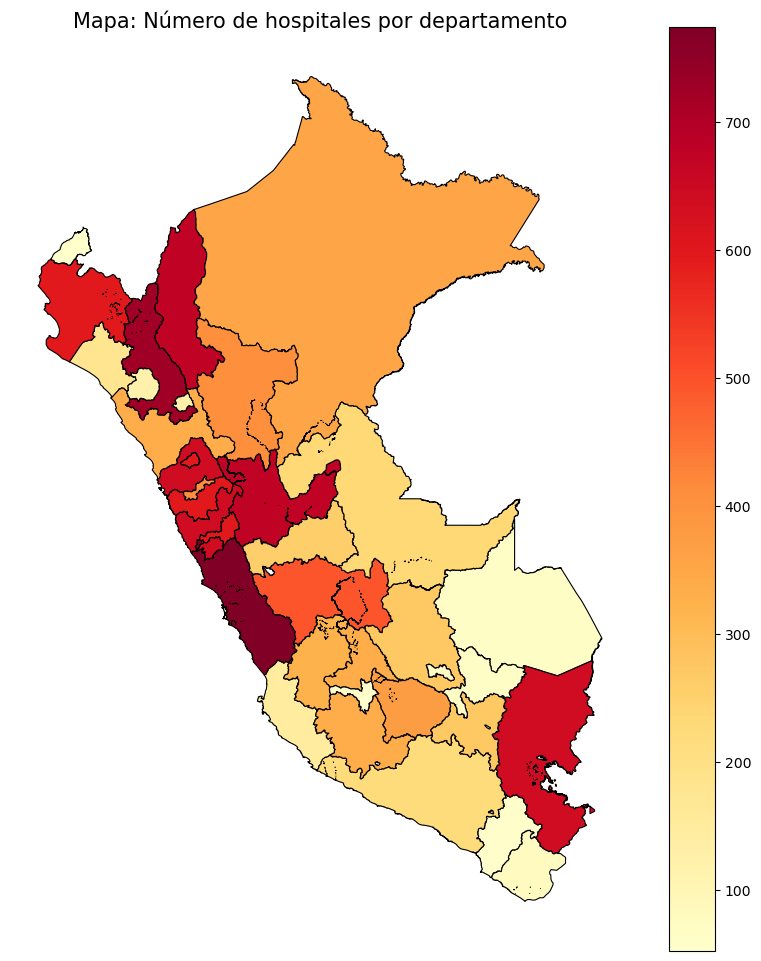

In [142]:
# Mapa coroplético a nivel departamental

# Extraer código de departamento
distritos["DEPTO_COD"] = distritos["UBIGEO"].astype(str).str[:2]

# Disolver por código de departamento
departamentos = distritos.dissolve(by="DEPTO_COD").reset_index()

#Filtrar hospitales operativos y con coordenadas válidas
hospitales = hospitales[hospitales["Condición"] == "EN FUNCIONAMIENTO"]  # Solo hospitales en funcionamiento
hospitales = hospitales.dropna(subset=["ESTE", "NORTE"])  # Mantener solo con coordenadas válidas

# Crear GeoDataFrame de hospitales
hospitales_gdf = gpd.GeoDataFrame(
    hospitales,
    geometry=gpd.points_from_xy(hospitales["ESTE"], hospitales["NORTE"]),
    crs="EPSG:4326"  # WGS-84
)

#UBIGEO para departamentos
distritos["DEPTO_COD"] = distritos["UBIGEO"].astype(str).str[:2]

# Para hospitales
hospitales_gdf["DEPTO_COD"] = hospitales_gdf["UBIGEO"].astype(str).str[:2]

#Agrupar por departamento:
hospitales_departamento = (
    hospitales_gdf.groupby("DEPTO_COD")
    .size()
    .reset_index(name="num_hospitales")
    .sort_values("num_hospitales", ascending=False)
)

departamentos = distritos.dissolve(by="DEPTO_COD").reset_index()

#Unir geometría con departamento
departamentos_hosp = departamentos.merge(
    hospitales_departamento,
    on="DEPTO_COD",
    how="left"
).fillna(0)  # llenar con 0 departamentos sin hospitales

# Mapa coroplético de hospitales por departamento

fig, ax = plt.subplots(figsize=(10,12))
departamentos_hosp.plot(
    column="num_hospitales",
    cmap="YlOrRd",  # Paleta de colores
    linewidth=0.8,
    edgecolor="black",
    legend=True,
    ax=ax
)
ax.set_title("Mapa: Número de hospitales por departamento", fontsize=15)
ax.axis("off")
plt.show()